# AI6126 ACV Project 1


In [1]:
nb_ver = 0.9
title = f'ai6126-project1-colab-v{nb_ver}'
print(title)
comments = "adamwf"
print(comments)

ai6126-project1-colab-v0.9
adamwf


## Versioning & References

### Changelogs
+ V0.1 - Setup codes to download and unzip celeba to gDrive
+ V0.2 - Added training loop 
+ V0.3 - Added seeding + save/ load checkpoint
+ V0.4 - Added time taken + save output
+ V0.5 - Added RandomErasing to transforms
+ V0.6 - Added get_criterion (BinaryFocalLoss) - NOT WORKING YET
+ V0.7 - Added FaceAttrMobileNetV2 & FaceAttrResNeXt
+ V0.8 - Added Albumentations
+ V0.9 - Updated Optimizer

### References
+ [PyTorch Transfer Learning](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
+ [TWD fast.ai](https://towardsdatascience.com/real-time-multi-facial-attribute-detection-using-transfer-learning-and-haar-cascades-with-fastai-47ff59e36df0)

### Dependencies

In [2]:
# conda install pytorch torchvision cudatoolkit=10.2 -c pytorch
# conda install matplotlib
# conda install pandas
# conda install tqdm
# conda install -c conda-forge jupyterlab
# conda install -c conda-forge tensorboard
# conda install -c conda-forge protobuf # for tensorboard
# conda install nb_conda_kernels # auto add kernels

# conda install -c conda-forge imgaug
# conda install albumentations -c conda-forge

## Setup/ Configuration

### Colab

In [3]:
# you can choose to mount your Google Drive (optional)
import sys, os
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    file_name = f'ai6126-project1-colab-v{nb_ver}.ipynb'
    print(file_name)
    import subprocess
    path_to_file = subprocess.check_output('find . -type f -name ' + str(file_name), shell=True).decode("utf-8")
    print(path_to_file)
    path_to_file = path_to_file.replace(file_name,"").replace('\n',"")
    os.chdir(path_to_file)
    !pwd

In [4]:
# check nvcc version
!nvcc -V
# check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:12:52_Pacific_Daylight_Time_2019
Cuda compilation tools, release 10.1, V10.1.243


'gcc' is not recognized as an internal or external command,
operable program or batch file.


### Download Dataset

In [5]:
import os, glob
local_download_path = '../data/celeba/img_align_celeba'
download_dataset = True
if os.path.exists(local_download_path):
    images = glob.glob(local_download_path + '/*.jpg')
    if len(images) == 202599:
        download_dataset = False
print(f"download celeba dataset: {download_dataset}")

if download_dataset:
    # create dataset root and enter it
    !mkdir -p data/celeba
    %cd data/celeba

    # we have prepared a backup of `img_align_celeba.zip` of Celeb-A dataset in the Dropbox
    # download it directly, or manually download the original file from Google Drive above
    !wget https://www.dropbox.com/s/8kzo40fqx7nodat/img_align_celeba.zip

    # unzip the downloaded file
    !unzip -qq img_align_celeba.zip
    !rm -f img_align_celeba.zip

    # change the directory back to the root
    %cd ../..
    !ls

download celeba dataset: False


## Implementation

### Imports

In [6]:
import sys, os
import time
import random
import numpy as np
import copy
from datetime import datetime
from distutils.dir_util import copy_tree #for recursive filecopying

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.tensorboard import SummaryWriter

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

from tqdm import tqdm
import matplotlib.pyplot as plt

import config
from celeba_dataset import CelebaDataset
import models
import losses
from utils import Logger, AverageMeter, Bar, savefig, adjust_learning_rate, accuracy, reset_gpu_cache, print_attribute_acc, create_dir_ifne

In [7]:
# set the backend of matplotlib to the 'inline' backend
%matplotlib inline

# check PyTorch version and cuda status
print(torch.__version__, torch.cuda.is_available())

# define device
device = torch.device("cuda:"+config.gpu_id if torch.cuda.is_available() else "cpu")
print(device)

if 'ipykernel' in sys.modules:
    config.disable_tqdm = False
print(f"disable_tqdm: {config.disable_tqdm}")

1.6.0 True
cuda:0
disable_tqdm: False


### Seeding

In [8]:
# set random seed for reproducibility
def seed_everything(seed=None):
    if seed is None:
        seed = random.randint(1, 10000) # create random seed
        print(f'random seed used: {seed}')
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    if 'torch' in sys.modules:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True
    
seed_everything(seed=config.manual_seed)

### Data Transform

In [9]:
# attribute_names = ['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 
#                    'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 
#                    'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
#                    'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 
#                    'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
#                    'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 
#                    'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']
# print(attribute_names)

In [10]:
# Data augmentation and normalization for training
# Just normalization for validation and testing

def load_dataloaders(print_info=True, albu_transforms = True):
    if config.evaluate:
        phases = ['test']
    else:
        phases = ['train', 'val']

    attribute_names = ['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 
                       'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 
                       'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
                       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 
                       'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
                       'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 
                       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']
    
    attributes_list = {
        'train': config.TRAIN_ATTRIBUTE_LIST,
        'val': config.VAL_ATTRIBUTE_LIST,
        'test': config.TEST_ATTRIBUTE_LIST
    }

    batch_sizes = {
        'train': config.train_batch,
        'val': config.test_batch,
        'test': config.test_batch
    }

    if not albu_transforms:
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
        data_transforms = {
            'train': transforms.Compose([
                transforms.Resize(128), #new
                transforms.CenterCrop(128), #new
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(degrees=10), #new
                transforms.ToTensor(),
                normalize,
                transforms.RandomErasing()
            ]),
            'val': transforms.Compose([
                transforms.Resize(128), #new
                transforms.ToTensor(),
                normalize
            ]),
            'test': transforms.Compose([
                transforms.Resize(128), #new
                transforms.ToTensor(),
                normalize
            ])
        }
    else:
        normalize_A = A.Normalize(mean=(0.485, 0.456, 0.406), 
                                  std=(0.229, 0.224, 0.225))
        data_transforms = {
            'train': A.Compose(
            [
                A.SmallestMaxSize(max_size=160),
                A.HorizontalFlip(p=0.5),
                A.MotionBlur(p=0.1),
                A.GaussNoise(p=0.5),
                A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, 
                                   rotate_limit=15, p=0.5),
                A.RandomBrightnessContrast(p=0.5),
                #A.CoarseDropout(),
                normalize_A,
                ToTensorV2(),
                
            ]),
            'val': A.Compose(
                [
                    A.SmallestMaxSize(max_size=160),
                    #A.CenterCrop(height=128, width=128),
                    normalize_A,
                    ToTensorV2(),
                ]
            ),
            'test': A.Compose([
                A.SmallestMaxSize(max_size=160),
                #A.CenterCrop(height=128, width=128),
                normalize_A,
                ToTensorV2(),
            ])
        }

    image_datasets = {x: CelebaDataset(config.IMG_DIR, attributes_list[x], 
                                       data_transforms[x]) 
                      for x in phases}
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                                  batch_size=batch_sizes[x],
                                                  pin_memory=True, shuffle=(x == 'train'), 
                                                  num_workers=config.dl_workers) 
                   for x in phases}
    if print_info:
        dataset_sizes = {x: len(image_datasets[x]) for x in phases}
        print(f"Dataset sizes: {dataset_sizes}")
        
    if config.evaluate:
        class_names = image_datasets['test'].targets
    else:
        class_names = image_datasets['train'].targets
    print(f"Class Labels: {len(class_names[0])}")
    assert len(attribute_names) == len(class_names[0])
    return dataloaders, attribute_names

### Model Architecture Initialization

In [11]:
model_names = sorted(name for name in models.__dict__
                     if callable(models.__dict__[name])) # and name.islower() and not name.startswith("__"))
print(f"Available Models: {model_names}")

Available Models: ['FaceAttrMobileNetV2', 'FaceAttrResNeXt', 'FaceAttrResNet']


In [12]:
def create_model(device):
    print("=> creating model '{}'".format(config.arch))
    if config.arch.startswith('FaceAttrResNet'):
        model = models.__dict__[config.arch](resnet_layers = config.pt_layers)
    elif config.arch.startswith('FaceAttrResNeXt'):
        model = models.__dict__[config.arch](resnet_layers = config.pt_layers)
    elif config.arch.startswith('FaceAttrMobileNetV2'):
        model = models.__dict__[config.arch]()
    #print(model)
    model = model.to(device)
    return model
#print(model)

### Criterion & Optimizer

In [13]:
def get_criterion():
    criterion = nn.CrossEntropyLoss().to(device)
    if config.criterion == 'BinaryFocalLoss':
        criterion = losses.BinaryFocalLoss().to(device)
    elif config.criterion == 'FocalLoss':
        criterion = losses.FocalLoss(alpha=0.25, gamma=5, reduction='mean').to(device)
    return criterion

In [14]:
def get_optimizer(model):
    optimizer = torch.optim.SGD(model.parameters(), config.lr,
                            momentum=config.momentum,
                            weight_decay=config.weight_decay)
    if config.optimizer == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), config.lr,
                            weight_decay=config.weight_decay)
    elif config.optimizer == 'AdamW':
        optimizer = torch.optim.AdamW(model.parameters(), config.lr,
                            weight_decay=config.weight_decay)
    return optimizer

### Resume Checkpoint if any

In [15]:
def resume_checkpoint(model, optimizer, ckp_logger_fname, ckp_resume=None):
    if not os.path.isdir(config.CHECKPOINT_DIR):
        try: 
            os.makedirs(config.CHECKPOINT_DIR)
        except OSError:
            raise
            
    start_epoch = 0
    best_prec1 = 0
    if ckp_resume and os.path.isfile(ckp_resume): 
        print(f"=> resuming model: {ckp_resume}")
        optimizer, start_epoch, best_prec1 = model.load_ckp(optimizer, ckp_resume)
        config.checkpoint = os.path.dirname(ckp_resume)
        logger = Logger(ckp_logger_fname, title=model.name, resume=True)
    else:
        logger = Logger(ckp_logger_fname, title=model.name)
        logger.set_names(['Learning Rate', 'Train Loss', 'Valid Loss', 'Train Acc.', 'Valid Acc.'])
        
        
    return best_prec1, start_epoch, logger

## Train & Validate Function

In [16]:
def train(train_loader, model, criterion, optimizer):
    bar = Bar('Processing', max=len(train_loader))

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = [AverageMeter() for _ in range(40)]
    top1 = [AverageMeter() for _ in range(40)]

    # switch to train mode
    model.train()

    end = time.time()
    for i, (X, y) in enumerate(tqdm(train_loader, disable=config.disable_tqdm)):
        # measure data loading time
        data_time.update(time.time() - end)

        # Overlapping transfer if pinned memory
        X = X.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
    
        # compute output
        output = model(X)
        # measure accuracy and record loss
        loss = []
        prec1 = []
        for j in range(len(output)): 
            # output[j]: [N,C] y[:,j]:[N]
            # CE Criterion: [] scalar
#             print("output s: ", output[j].shape)
#             print("output y: ", y[:, j].shape)
            crit = criterion(output[j], y[:, j])
#             print(crit.detach())
            loss.append(crit)
            prec1.append(accuracy(output[j], y[:, j], topk=(1,)))
            losses[j].update(loss[j].detach().item(), X.size(0))
            top1[j].update(prec1[j][0].item(), X.size(0))
            
        losses_avg = [losses[k].avg for k in range(len(losses))]
        top1_avg = [top1[k].avg for k in range(len(top1))]
        loss_avg = sum(losses_avg) / len(losses_avg)
        prec1_avg = sum(top1_avg) / len(top1_avg)

        # compute gradient and do optimizer step
        optimizer.zero_grad()
        loss_sum = sum(loss)
        loss_sum.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # plot progress
        print_line = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | Loss: {loss:.4f} | top1: {top1: .4f}'.format(
                        batch=i + 1,
                        size=len(train_loader),
                        data=data_time.avg,
                        bt=batch_time.avg,
                        total=bar.elapsed_td,
                        eta=bar.eta_td,
                        loss=loss_avg,
                        top1=prec1_avg,
                        )
        if not config.disable_tqdm and (i+1)% 100 == 0:
            print(print_line)
        bar.suffix  = print_line
        bar.next()
    bar.finish()
    return (loss_avg, prec1_avg)

In [17]:
def validate(val_loader, model, criterion):
    bar = Bar('Processing', max=len(val_loader))

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = [AverageMeter() for _ in range(40)]
    top1 = [AverageMeter() for _ in range(40)]

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for i, (X, y) in enumerate(tqdm(val_loader, disable=config.disable_tqdm)):
            # measure data loading time
            data_time.update(time.time() - end)

            # Overlapping transfer if pinned memory
            X = X.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            # compute output
            output = model(X)
            # measure accuracy and record loss
            loss = []
            prec1 = []
            for j in range(len(output)):
                loss.append(criterion(output[j], y[:, j]))
                prec1.append(accuracy(output[j], y[:, j], topk=(1,)))
                
                losses[j].update(loss[j].detach().item(), X.size(0))
                top1[j].update(prec1[j][0].item(), X.size(0))
            losses_avg = [losses[k].avg for k in range(len(losses))]
            top1_avg = [top1[k].avg for k in range(len(top1))]
            loss_avg = sum(losses_avg) / len(losses_avg)
            prec1_avg = sum(top1_avg) / len(top1_avg)

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()
            
            # plot progress
            print_line = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | Loss: {loss:.4f} | top1: {top1: .4f}'.format(
                            batch=i + 1,
                            size=len(val_loader),
                            data=data_time.avg,
                            bt=batch_time.avg,
                            total=bar.elapsed_td,
                            eta=bar.eta_td,
                            loss=loss_avg,
                            top1=prec1_avg,
                            )

            bar.suffix  = print_line
            bar.next()  

    if not config.disable_tqdm:
        print(print_line)        
    bar.finish()
    return (loss_avg, prec1_avg, top1)

## Main Function

In [18]:
def trainer(dataloaders, model, criterion, optimizer, logger, start_epoch, best_prec1, run_name):
    # visualization
    writer = SummaryWriter(os.path.join(config.tensorboard_dir, run_name))
    
    for epoch in range(start_epoch, config.epochs):
        start_time = time.time()
        lr = adjust_learning_rate(optimizer, config.lr_decay, epoch, gamma=config.gamma, step=config.step,
                                 total_epochs=config.epochs, turning_point=config.turning_point,
                                 schedule=config.schedule)

        print('\nEpoch: [%d | %d] LR: %.16f' % (epoch + 1, config.epochs, lr))

        # train for one epoch
        train_loss, train_acc = train(dataloaders['train'], model, criterion, optimizer)

        # evaluate on validation set
        val_loss, prec1, _ = validate(dataloaders['val'], model, criterion)

        # append logger file
        logger.append([lr, train_loss, val_loss, train_acc, prec1])

        # tensorboardX
        writer.add_scalar('learning rate', lr, epoch + 1)
        writer.add_scalars('loss', {'train loss': train_loss, 'validation loss': val_loss}, epoch + 1)
        writer.add_scalars('accuracy', {'train accuracy': train_acc, 'validation accuracy': prec1}, epoch + 1)
        #for name, param in model.named_parameters():
        #    writer.add_histogram(name, param.clone().cpu().data.numpy(), epoch + 1)

        is_best = prec1 > best_prec1
        best_prec1 = max(prec1, best_prec1)
        ttt += time.time()-start_time
        model.save_ckp({
            'epoch': epoch + 1,
            'arch': model.name,
            'state_dict': model.state_dict(),
            'best_prec1': best_prec1,
            'optimizer' : optimizer.state_dict(),
            'lr': lr,
            'total_time': ttt
        }, is_best, config.checkpoint_fname,config.bestmodel_fname)

    logger.close()
    logger.plot()
    savefig(config.train_plotfig)
    writer.close()

    print('Best accuracy:')
    print(best_prec1)

In [19]:
def get_run_name_time(model, criterion, optimizer, comments):
    try:
        if criterion.name:
            p_criterion = criterion.name
    except:
        p_criterion = 'CE'

    p_optimizer = f'{str(optimizer).split("(")[0].strip()}'
    p_scheduler = f'{config.lr_decay}_lr{config.lr}_wd{config.weight_decay}'
    if config.lr_decay == 'step':
        p_scheduler += f'_g{config.gamma}_sp{config.step}'
    elif config.lr_decay == 'linear2exp':
        p_scheduler += f'_g{config.gamma}_tp{config.turning_point}'
    elif config.lr_decay == 'schedule':
        p_scheduler += f'_g{config.gamma}_sch{config.schedule}'

    run_name = f'{model.name}_{config.manual_seed}_s{start_epoch}e{config.epochs}_' \
                + f'tb{config.train_batch}_vb{config.test_batch}_' \
                + f'{p_criterion}_{p_optimizer}_' \
                + f'{comments}_' \
                + f'{p_scheduler}'
    
    run_time = datetime.now().strftime("%Y%m%d_%H%M%S")
    print(run_name, run_time)
    return run_name, run_time

## Training Loop

=> creating model 'FaceAttrResNet'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]

Dataset sizes: {'train': 162770, 'val': 19867}
Class Labels: 40
FaceAttrResNet18_42_s0e50_tb256_vb128_FL_AdamW_adamwf_step_lr0.01_wd0.0001_g0.1_sp30 20201006_230339

Epoch: [1 | 50] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [02:43<13:39,  1.53s/it]

(100/636) Data: 1.109s | Batch: 1.632s | Total: 0:02:43 | ETA: 0:16:59 | Loss: 0.0131 | top1:  78.9523


 31%|█████████████████████████▏                                                      | 200/636 [05:01<07:50,  1.08s/it]

(200/636) Data: 0.998s | Batch: 1.507s | Total: 0:05:01 | ETA: 0:10:02 | Loss: 0.0110 | top1:  79.5906


 47%|█████████████████████████████████████▋                                          | 300/636 [07:05<05:44,  1.03s/it]

(300/636) Data: 0.933s | Batch: 1.419s | Total: 0:07:05 | ETA: 0:06:59 | Loss: 0.0098 | top1:  79.8143


 63%|██████████████████████████████████████████████████▎                             | 400/636 [09:01<04:21,  1.11s/it]

(400/636) Data: 0.870s | Batch: 1.355s | Total: 0:09:01 | ETA: 0:04:14 | Loss: 0.0094 | top1:  79.9216


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [10:46<02:06,  1.07it/s]

(500/636) Data: 0.802s | Batch: 1.292s | Total: 0:10:46 | ETA: 0:02:33 | Loss: 0.0090 | top1:  80.0036


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [12:33<00:35,  1.01it/s]

(600/636) Data: 0.768s | Batch: 1.256s | Total: 0:12:33 | ETA: 0:00:38 | Loss: 0.0086 | top1:  80.0722


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:28<00:00,  5.43it/s]


(156/156) Data: 0.057s | Batch: 0.181s | Total: 0:00:28 | ETA: 0:00:01 | Loss: 0.0116 | top1:  80.6584
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'
=> saving best model 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [2 | 50] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:11<05:17,  1.69it/s]

(100/636) Data: 0.118s | Batch: 0.717s | Total: 0:01:11 | ETA: 0:05:18 | Loss: 0.0063 | top1:  80.5129


 31%|█████████████████████████▏                                                      | 200/636 [02:10<04:17,  1.69it/s]

(200/636) Data: 0.060s | Batch: 0.654s | Total: 0:02:10 | ETA: 0:04:19 | Loss: 0.0062 | top1:  80.5150


 47%|█████████████████████████████████████▋                                          | 300/636 [03:09<03:18,  1.69it/s]

(300/636) Data: 0.040s | Batch: 0.633s | Total: 0:03:09 | ETA: 0:03:20 | Loss: 0.0062 | top1:  80.4867


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:08<02:19,  1.69it/s]

(400/636) Data: 0.031s | Batch: 0.622s | Total: 0:04:08 | ETA: 0:02:21 | Loss: 0.0061 | top1:  80.4945


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:08<01:20,  1.69it/s]

(500/636) Data: 0.025s | Batch: 0.616s | Total: 0:05:08 | ETA: 0:01:21 | Loss: 0.0059 | top1:  80.5114


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:07<00:21,  1.69it/s]

(600/636) Data: 0.021s | Batch: 0.612s | Total: 0:06:07 | ETA: 0:00:22 | Loss: 0.0058 | top1:  80.5087


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.96it/s]


(156/156) Data: 0.050s | Batch: 0.165s | Total: 0:00:25 | ETA: 0:00:01 | Loss: 0.0036 | top1:  80.7813
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'
=> saving best model 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [3 | 50] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:10<05:17,  1.69it/s]

(100/636) Data: 0.118s | Batch: 0.709s | Total: 0:01:10 | ETA: 0:05:18 | Loss: 0.0046 | top1:  80.4644


 31%|█████████████████████████▏                                                      | 200/636 [02:09<04:17,  1.69it/s]

(200/636) Data: 0.060s | Batch: 0.650s | Total: 0:02:09 | ETA: 0:04:19 | Loss: 0.0044 | top1:  80.4795


 47%|█████████████████████████████████████▋                                          | 300/636 [03:09<03:18,  1.69it/s]

(300/636) Data: 0.040s | Batch: 0.630s | Total: 0:03:09 | ETA: 0:03:19 | Loss: 0.0046 | top1:  80.4437


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:08<02:19,  1.69it/s]

(400/636) Data: 0.031s | Batch: 0.621s | Total: 0:04:08 | ETA: 0:02:20 | Loss: 0.0046 | top1:  80.4692


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:07<01:20,  1.70it/s]

(500/636) Data: 0.025s | Batch: 0.615s | Total: 0:05:07 | ETA: 0:01:21 | Loss: 0.0045 | top1:  80.4714


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:06<00:21,  1.69it/s]

(600/636) Data: 0.021s | Batch: 0.611s | Total: 0:06:06 | ETA: 0:00:22 | Loss: 0.0045 | top1:  80.4732


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.96it/s]


(156/156) Data: 0.052s | Batch: 0.165s | Total: 0:00:25 | ETA: 0:00:01 | Loss: 0.0038 | top1:  80.6603
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [4 | 50] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:11<05:16,  1.69it/s]

(100/636) Data: 0.121s | Batch: 0.712s | Total: 0:01:11 | ETA: 0:05:18 | Loss: 0.0040 | top1:  80.3996


 31%|█████████████████████████▏                                                      | 200/636 [02:09<04:17,  1.69it/s]

(200/636) Data: 0.061s | Batch: 0.649s | Total: 0:02:09 | ETA: 0:04:18 | Loss: 0.0040 | top1:  80.4383


 47%|█████████████████████████████████████▋                                          | 300/636 [03:08<03:18,  1.69it/s]

(300/636) Data: 0.041s | Batch: 0.629s | Total: 0:03:08 | ETA: 0:03:19 | Loss: 0.0040 | top1:  80.4580


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:07<02:19,  1.69it/s]

(400/636) Data: 0.031s | Batch: 0.620s | Total: 0:04:07 | ETA: 0:02:20 | Loss: 0.0040 | top1:  80.4610


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:06<01:20,  1.69it/s]

(500/636) Data: 0.025s | Batch: 0.614s | Total: 0:05:06 | ETA: 0:01:22 | Loss: 0.0040 | top1:  80.4803


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:06<00:21,  1.69it/s]

(600/636) Data: 0.021s | Batch: 0.610s | Total: 0:06:06 | ETA: 0:00:22 | Loss: 0.0039 | top1:  80.4858


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.99it/s]


(156/156) Data: 0.050s | Batch: 0.164s | Total: 0:00:25 | ETA: 0:00:01 | Loss: 0.0042 | top1:  80.7312
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [5 | 50] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:10<05:17,  1.69it/s]

(100/636) Data: 0.115s | Batch: 0.702s | Total: 0:01:10 | ETA: 0:05:18 | Loss: 0.0038 | top1:  80.5360


 31%|█████████████████████████▏                                                      | 200/636 [02:09<04:17,  1.70it/s]

(200/636) Data: 0.058s | Batch: 0.646s | Total: 0:02:09 | ETA: 0:04:18 | Loss: 0.0038 | top1:  80.5175


 47%|█████████████████████████████████████▋                                          | 300/636 [03:08<03:18,  1.69it/s]

(300/636) Data: 0.039s | Batch: 0.628s | Total: 0:03:08 | ETA: 0:03:19 | Loss: 0.0038 | top1:  80.5315


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:07<02:19,  1.70it/s]

(400/636) Data: 0.030s | Batch: 0.619s | Total: 0:04:07 | ETA: 0:02:20 | Loss: 0.0037 | top1:  80.5635


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:06<01:20,  1.69it/s]

(500/636) Data: 0.024s | Batch: 0.613s | Total: 0:05:06 | ETA: 0:01:21 | Loss: 0.0037 | top1:  80.5582


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:05<00:21,  1.69it/s]

(600/636) Data: 0.020s | Batch: 0.609s | Total: 0:06:05 | ETA: 0:00:22 | Loss: 0.0037 | top1:  80.5489


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.96it/s]


(156/156) Data: 0.052s | Batch: 0.165s | Total: 0:00:25 | ETA: 0:00:01 | Loss: 0.0038 | top1:  80.7808
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [6 | 50] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:10<05:17,  1.69it/s]

(100/636) Data: 0.118s | Batch: 0.709s | Total: 0:01:10 | ETA: 0:05:18 | Loss: 0.0036 | top1:  81.1248


 31%|█████████████████████████▏                                                      | 200/636 [02:09<04:17,  1.69it/s]

(200/636) Data: 0.060s | Batch: 0.650s | Total: 0:02:09 | ETA: 0:04:19 | Loss: 0.0036 | top1:  81.5457


 47%|█████████████████████████████████████▋                                          | 300/636 [03:09<03:19,  1.69it/s]

(300/636) Data: 0.040s | Batch: 0.630s | Total: 0:03:09 | ETA: 0:03:19 | Loss: 0.0035 | top1:  81.7912


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:08<02:19,  1.69it/s]

(400/636) Data: 0.031s | Batch: 0.620s | Total: 0:04:08 | ETA: 0:02:21 | Loss: 0.0035 | top1:  81.9916


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:07<01:20,  1.69it/s]

(500/636) Data: 0.025s | Batch: 0.614s | Total: 0:05:07 | ETA: 0:01:21 | Loss: 0.0035 | top1:  81.8849


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:06<00:21,  1.69it/s]

(600/636) Data: 0.021s | Batch: 0.610s | Total: 0:06:06 | ETA: 0:00:22 | Loss: 0.0035 | top1:  81.7186


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.97it/s]


(156/156) Data: 0.050s | Batch: 0.165s | Total: 0:00:25 | ETA: 0:00:01 | Loss: 0.0036 | top1:  81.1328
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'
=> saving best model 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [7 | 50] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:10<05:16,  1.69it/s]

(100/636) Data: 0.116s | Batch: 0.707s | Total: 0:01:10 | ETA: 0:05:17 | Loss: 0.0034 | top1:  82.1115


 31%|█████████████████████████▏                                                      | 200/636 [02:09<04:17,  1.69it/s]

(200/636) Data: 0.059s | Batch: 0.649s | Total: 0:02:09 | ETA: 0:04:18 | Loss: 0.0034 | top1:  82.3471


 47%|█████████████████████████████████████▋                                          | 300/636 [03:08<03:18,  1.69it/s]

(300/636) Data: 0.040s | Batch: 0.630s | Total: 0:03:08 | ETA: 0:03:20 | Loss: 0.0033 | top1:  82.4847


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:08<02:19,  1.69it/s]

(400/636) Data: 0.030s | Batch: 0.620s | Total: 0:04:08 | ETA: 0:02:21 | Loss: 0.0033 | top1:  82.6252


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:07<01:20,  1.69it/s]

(500/636) Data: 0.024s | Batch: 0.614s | Total: 0:05:07 | ETA: 0:01:21 | Loss: 0.0033 | top1:  82.7472


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:06<00:21,  1.69it/s]

(600/636) Data: 0.021s | Batch: 0.610s | Total: 0:06:06 | ETA: 0:00:22 | Loss: 0.0033 | top1:  82.8867


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.99it/s]


(156/156) Data: 0.050s | Batch: 0.164s | Total: 0:00:25 | ETA: 0:00:01 | Loss: 0.0030 | top1:  84.3065
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'
=> saving best model 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [8 | 50] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:10<05:16,  1.69it/s]

(100/636) Data: 0.116s | Batch: 0.710s | Total: 0:01:10 | ETA: 0:05:18 | Loss: 0.0031 | top1:  83.8947


 31%|█████████████████████████▏                                                      | 200/636 [02:10<04:17,  1.69it/s]

(200/636) Data: 0.059s | Batch: 0.650s | Total: 0:02:10 | ETA: 0:04:19 | Loss: 0.0030 | top1:  83.9772


 47%|█████████████████████████████████████▋                                          | 300/636 [03:09<03:18,  1.69it/s]

(300/636) Data: 0.040s | Batch: 0.630s | Total: 0:03:09 | ETA: 0:03:19 | Loss: 0.0030 | top1:  84.0524


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:08<02:19,  1.69it/s]

(400/636) Data: 0.030s | Batch: 0.620s | Total: 0:04:08 | ETA: 0:02:20 | Loss: 0.0030 | top1:  84.1264


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:07<01:20,  1.69it/s]

(500/636) Data: 0.024s | Batch: 0.615s | Total: 0:05:07 | ETA: 0:01:21 | Loss: 0.0030 | top1:  84.2104


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:06<00:21,  1.69it/s]

(600/636) Data: 0.021s | Batch: 0.611s | Total: 0:06:06 | ETA: 0:00:22 | Loss: 0.0030 | top1:  84.3237


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.96it/s]


(156/156) Data: 0.049s | Batch: 0.165s | Total: 0:00:25 | ETA: 0:00:01 | Loss: 0.0030 | top1:  84.0834
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [9 | 50] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:11<05:16,  1.69it/s]

(100/636) Data: 0.119s | Batch: 0.712s | Total: 0:01:11 | ETA: 0:05:17 | Loss: 0.0028 | top1:  85.4900


 31%|█████████████████████████▏                                                      | 200/636 [02:10<04:17,  1.69it/s]

(200/636) Data: 0.060s | Batch: 0.651s | Total: 0:02:10 | ETA: 0:04:19 | Loss: 0.0028 | top1:  85.7171


 47%|█████████████████████████████████████▋                                          | 300/636 [03:09<03:18,  1.69it/s]

(300/636) Data: 0.041s | Batch: 0.631s | Total: 0:03:09 | ETA: 0:03:19 | Loss: 0.0028 | top1:  85.8744


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:08<02:19,  1.69it/s]

(400/636) Data: 0.031s | Batch: 0.621s | Total: 0:04:08 | ETA: 0:02:21 | Loss: 0.0027 | top1:  86.0148


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:07<01:20,  1.69it/s]

(500/636) Data: 0.025s | Batch: 0.615s | Total: 0:05:07 | ETA: 0:01:21 | Loss: 0.0027 | top1:  86.0862


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:06<00:21,  1.69it/s]

(600/636) Data: 0.021s | Batch: 0.611s | Total: 0:06:06 | ETA: 0:00:22 | Loss: 0.0027 | top1:  86.1178


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.97it/s]


(156/156) Data: 0.049s | Batch: 0.165s | Total: 0:00:25 | ETA: 0:00:01 | Loss: 0.0026 | top1:  87.1443
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'
=> saving best model 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [10 | 50] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:11<05:18,  1.68it/s]

(100/636) Data: 0.120s | Batch: 0.710s | Total: 0:01:11 | ETA: 0:05:19 | Loss: 0.0026 | top1:  86.6933


 31%|█████████████████████████▏                                                      | 200/636 [02:10<04:17,  1.69it/s]

(200/636) Data: 0.061s | Batch: 0.650s | Total: 0:02:10 | ETA: 0:04:19 | Loss: 0.0026 | top1:  86.8628


 47%|█████████████████████████████████████▋                                          | 300/636 [03:09<03:18,  1.70it/s]

(300/636) Data: 0.041s | Batch: 0.631s | Total: 0:03:09 | ETA: 0:03:19 | Loss: 0.0026 | top1:  86.9557


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:08<02:19,  1.69it/s]

(400/636) Data: 0.031s | Batch: 0.621s | Total: 0:04:08 | ETA: 0:02:21 | Loss: 0.0025 | top1:  87.0595


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:07<01:20,  1.69it/s]

(500/636) Data: 0.025s | Batch: 0.615s | Total: 0:05:07 | ETA: 0:01:21 | Loss: 0.0025 | top1:  87.1539


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:06<00:21,  1.69it/s]

(600/636) Data: 0.021s | Batch: 0.611s | Total: 0:06:06 | ETA: 0:00:22 | Loss: 0.0025 | top1:  87.2219


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.97it/s]


(156/156) Data: 0.049s | Batch: 0.164s | Total: 0:00:25 | ETA: 0:00:01 | Loss: 0.0264 | top1:  80.4983
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [11 | 50] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:10<05:16,  1.69it/s]

(100/636) Data: 0.115s | Batch: 0.708s | Total: 0:01:10 | ETA: 0:05:18 | Loss: 0.0029 | top1:  85.6473


 31%|█████████████████████████▏                                                      | 200/636 [02:09<04:17,  1.69it/s]

(200/636) Data: 0.058s | Batch: 0.649s | Total: 0:02:09 | ETA: 0:04:19 | Loss: 0.0027 | top1:  86.2208


 47%|█████████████████████████████████████▋                                          | 300/636 [03:08<03:18,  1.69it/s]

(300/636) Data: 0.039s | Batch: 0.630s | Total: 0:03:08 | ETA: 0:03:19 | Loss: 0.0027 | top1:  86.5340


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:08<02:19,  1.69it/s]

(400/636) Data: 0.030s | Batch: 0.620s | Total: 0:04:08 | ETA: 0:02:21 | Loss: 0.0026 | top1:  86.6971


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:07<01:20,  1.69it/s]

(500/636) Data: 0.024s | Batch: 0.614s | Total: 0:05:07 | ETA: 0:01:21 | Loss: 0.0026 | top1:  86.7439


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:06<00:21,  1.69it/s]

(600/636) Data: 0.020s | Batch: 0.611s | Total: 0:06:06 | ETA: 0:00:22 | Loss: 0.0026 | top1:  86.8122


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.98it/s]


(156/156) Data: 0.050s | Batch: 0.164s | Total: 0:00:25 | ETA: 0:00:01 | Loss: 0.0028 | top1:  86.7652
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [12 | 50] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:11<05:16,  1.69it/s]

(100/636) Data: 0.119s | Batch: 0.711s | Total: 0:01:11 | ETA: 0:05:17 | Loss: 0.0025 | top1:  87.3731


 31%|█████████████████████████▏                                                      | 200/636 [02:10<04:17,  1.69it/s]

(200/636) Data: 0.060s | Batch: 0.651s | Total: 0:02:10 | ETA: 0:04:19 | Loss: 0.0025 | top1:  87.4787


 47%|█████████████████████████████████████▋                                          | 300/636 [03:09<03:18,  1.69it/s]

(300/636) Data: 0.041s | Batch: 0.631s | Total: 0:03:09 | ETA: 0:03:20 | Loss: 0.0024 | top1:  87.5416


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:08<02:19,  1.69it/s]

(400/636) Data: 0.031s | Batch: 0.621s | Total: 0:04:08 | ETA: 0:02:20 | Loss: 0.0024 | top1:  87.6149


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:07<01:20,  1.69it/s]

(500/636) Data: 0.025s | Batch: 0.615s | Total: 0:05:07 | ETA: 0:01:21 | Loss: 0.0024 | top1:  87.6720


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:06<00:20,  1.73it/s]

(600/636) Data: 0.021s | Batch: 0.611s | Total: 0:06:06 | ETA: 0:00:22 | Loss: 0.0024 | top1:  87.7208


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.94it/s]


(156/156) Data: 0.049s | Batch: 0.165s | Total: 0:00:25 | ETA: 0:00:01 | Loss: 0.0023 | top1:  88.4269
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'
=> saving best model 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [13 | 50] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:11<05:17,  1.69it/s]

(100/636) Data: 0.117s | Batch: 0.711s | Total: 0:01:11 | ETA: 0:05:18 | Loss: 0.0023 | top1:  88.1425


 31%|█████████████████████████▏                                                      | 200/636 [02:10<04:17,  1.69it/s]

(200/636) Data: 0.059s | Batch: 0.651s | Total: 0:02:10 | ETA: 0:04:19 | Loss: 0.0023 | top1:  88.1751


 47%|█████████████████████████████████████▋                                          | 300/636 [03:09<03:18,  1.69it/s]

(300/636) Data: 0.040s | Batch: 0.631s | Total: 0:03:09 | ETA: 0:03:20 | Loss: 0.0024 | top1:  87.8048


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:08<02:19,  1.69it/s]

(400/636) Data: 0.030s | Batch: 0.620s | Total: 0:04:08 | ETA: 0:02:20 | Loss: 0.0025 | top1:  87.3800


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:06<01:20,  1.70it/s]

(500/636) Data: 0.025s | Batch: 0.614s | Total: 0:05:06 | ETA: 0:01:21 | Loss: 0.0025 | top1:  87.3397


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:05<00:21,  1.69it/s]

(600/636) Data: 0.021s | Batch: 0.610s | Total: 0:06:05 | ETA: 0:00:22 | Loss: 0.0025 | top1:  87.3679


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.95it/s]


(156/156) Data: 0.050s | Batch: 0.165s | Total: 0:00:25 | ETA: 0:00:01 | Loss: 0.0023 | top1:  88.2525
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [14 | 50] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:10<05:15,  1.70it/s]

(100/636) Data: 0.118s | Batch: 0.708s | Total: 0:01:10 | ETA: 0:05:18 | Loss: 0.0023 | top1:  87.9906


 31%|█████████████████████████▏                                                      | 200/636 [02:09<04:17,  1.69it/s]

(200/636) Data: 0.060s | Batch: 0.649s | Total: 0:02:09 | ETA: 0:04:19 | Loss: 0.0023 | top1:  88.0873


 47%|█████████████████████████████████████▋                                          | 300/636 [03:08<03:18,  1.69it/s]

(300/636) Data: 0.040s | Batch: 0.629s | Total: 0:03:08 | ETA: 0:03:19 | Loss: 0.0023 | top1:  88.1480


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:07<02:20,  1.68it/s]

(400/636) Data: 0.031s | Batch: 0.620s | Total: 0:04:07 | ETA: 0:02:21 | Loss: 0.0023 | top1:  88.1857


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:06<01:20,  1.69it/s]

(500/636) Data: 0.025s | Batch: 0.614s | Total: 0:05:06 | ETA: 0:01:21 | Loss: 0.0023 | top1:  88.2302


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:05<00:21,  1.69it/s]

(600/636) Data: 0.021s | Batch: 0.610s | Total: 0:06:05 | ETA: 0:00:22 | Loss: 0.0023 | top1:  88.2826


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.96it/s]


(156/156) Data: 0.052s | Batch: 0.165s | Total: 0:00:25 | ETA: 0:00:01 | Loss: 0.0022 | top1:  89.0736
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'
=> saving best model 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [15 | 50] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:10<05:16,  1.70it/s]

(100/636) Data: 0.118s | Batch: 0.707s | Total: 0:01:10 | ETA: 0:05:17 | Loss: 0.0022 | top1:  88.6242


 31%|█████████████████████████▏                                                      | 200/636 [02:09<04:17,  1.69it/s]

(200/636) Data: 0.060s | Batch: 0.649s | Total: 0:02:09 | ETA: 0:04:18 | Loss: 0.0022 | top1:  88.6635


 47%|█████████████████████████████████████▋                                          | 300/636 [03:08<03:18,  1.69it/s]

(300/636) Data: 0.040s | Batch: 0.629s | Total: 0:03:08 | ETA: 0:03:20 | Loss: 0.0022 | top1:  88.6911


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:07<02:19,  1.69it/s]

(400/636) Data: 0.031s | Batch: 0.619s | Total: 0:04:07 | ETA: 0:02:20 | Loss: 0.0022 | top1:  88.5766


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:06<01:20,  1.69it/s]

(500/636) Data: 0.025s | Batch: 0.614s | Total: 0:05:06 | ETA: 0:01:21 | Loss: 0.0022 | top1:  88.5533


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:05<00:21,  1.69it/s]

(600/636) Data: 0.021s | Batch: 0.610s | Total: 0:06:05 | ETA: 0:00:22 | Loss: 0.0022 | top1:  88.5803


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.96it/s]


(156/156) Data: 0.051s | Batch: 0.165s | Total: 0:00:25 | ETA: 0:00:01 | Loss: 0.0021 | top1:  89.3003
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'
=> saving best model 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [16 | 50] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:11<05:16,  1.69it/s]

(100/636) Data: 0.120s | Batch: 0.712s | Total: 0:01:11 | ETA: 0:05:17 | Loss: 0.0022 | top1:  88.9870


 31%|█████████████████████████▏                                                      | 200/636 [02:10<04:17,  1.69it/s]

(200/636) Data: 0.061s | Batch: 0.651s | Total: 0:02:10 | ETA: 0:04:19 | Loss: 0.0021 | top1:  88.9951


 47%|█████████████████████████████████████▋                                          | 300/636 [03:09<03:18,  1.69it/s]

(300/636) Data: 0.041s | Batch: 0.631s | Total: 0:03:09 | ETA: 0:03:19 | Loss: 0.0021 | top1:  89.0054


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:08<02:19,  1.69it/s]

(400/636) Data: 0.031s | Batch: 0.621s | Total: 0:04:08 | ETA: 0:02:20 | Loss: 0.0021 | top1:  89.0380


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:07<01:20,  1.70it/s]

(500/636) Data: 0.025s | Batch: 0.615s | Total: 0:05:07 | ETA: 0:01:21 | Loss: 0.0021 | top1:  89.0559


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:06<00:21,  1.70it/s]

(600/636) Data: 0.021s | Batch: 0.611s | Total: 0:06:06 | ETA: 0:00:22 | Loss: 0.0021 | top1:  89.0805


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.94it/s]


(156/156) Data: 0.050s | Batch: 0.165s | Total: 0:00:25 | ETA: 0:00:01 | Loss: 0.0021 | top1:  89.4649
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'
=> saving best model 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [17 | 50] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:11<05:16,  1.69it/s]

(100/636) Data: 0.119s | Batch: 0.711s | Total: 0:01:11 | ETA: 0:05:17 | Loss: 0.0021 | top1:  89.2995


 31%|█████████████████████████▏                                                      | 200/636 [02:10<04:17,  1.69it/s]

(200/636) Data: 0.060s | Batch: 0.651s | Total: 0:02:10 | ETA: 0:04:18 | Loss: 0.0021 | top1:  89.3438


 47%|█████████████████████████████████████▋                                          | 300/636 [03:09<03:18,  1.69it/s]

(300/636) Data: 0.041s | Batch: 0.631s | Total: 0:03:09 | ETA: 0:03:19 | Loss: 0.0021 | top1:  89.3643


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:08<02:19,  1.69it/s]

(400/636) Data: 0.031s | Batch: 0.621s | Total: 0:04:08 | ETA: 0:02:21 | Loss: 0.0021 | top1:  89.3866


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:07<01:20,  1.69it/s]

(500/636) Data: 0.025s | Batch: 0.615s | Total: 0:05:07 | ETA: 0:01:21 | Loss: 0.0021 | top1:  89.4220


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:06<00:21,  1.69it/s]

(600/636) Data: 0.021s | Batch: 0.611s | Total: 0:06:06 | ETA: 0:00:22 | Loss: 0.0021 | top1:  89.4282


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.93it/s]


(156/156) Data: 0.051s | Batch: 0.166s | Total: 0:00:25 | ETA: 0:00:01 | Loss: 0.0019 | top1:  90.1394
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'
=> saving best model 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [18 | 50] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:11<05:16,  1.70it/s]

(100/636) Data: 0.121s | Batch: 0.711s | Total: 0:01:11 | ETA: 0:05:17 | Loss: 0.0020 | top1:  89.6369


 31%|█████████████████████████▏                                                      | 200/636 [02:10<04:17,  1.70it/s]

(200/636) Data: 0.061s | Batch: 0.651s | Total: 0:02:10 | ETA: 0:04:18 | Loss: 0.0020 | top1:  89.6505


 47%|█████████████████████████████████████▋                                          | 300/636 [03:09<03:18,  1.69it/s]

(300/636) Data: 0.041s | Batch: 0.631s | Total: 0:03:09 | ETA: 0:03:19 | Loss: 0.0020 | top1:  89.6552


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:08<02:19,  1.69it/s]

(400/636) Data: 0.031s | Batch: 0.621s | Total: 0:04:08 | ETA: 0:02:20 | Loss: 0.0020 | top1:  89.6410


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:07<01:20,  1.69it/s]

(500/636) Data: 0.025s | Batch: 0.615s | Total: 0:05:07 | ETA: 0:01:21 | Loss: 0.0020 | top1:  89.6504


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:06<00:21,  1.69it/s]

(600/636) Data: 0.021s | Batch: 0.611s | Total: 0:06:06 | ETA: 0:00:22 | Loss: 0.0020 | top1:  89.6672


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.94it/s]


(156/156) Data: 0.050s | Batch: 0.165s | Total: 0:00:25 | ETA: 0:00:01 | Loss: 0.0019 | top1:  90.2375
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'
=> saving best model 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [19 | 50] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:10<05:15,  1.70it/s]

(100/636) Data: 0.117s | Batch: 0.709s | Total: 0:01:10 | ETA: 0:05:17 | Loss: 0.0020 | top1:  89.8243


 31%|█████████████████████████▏                                                      | 200/636 [02:09<04:18,  1.68it/s]

(200/636) Data: 0.059s | Batch: 0.650s | Total: 0:02:09 | ETA: 0:04:18 | Loss: 0.0020 | top1:  89.8081


 47%|█████████████████████████████████████▋                                          | 300/636 [03:09<03:18,  1.69it/s]

(300/636) Data: 0.040s | Batch: 0.630s | Total: 0:03:09 | ETA: 0:03:20 | Loss: 0.0020 | top1:  89.8142


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:08<02:19,  1.69it/s]

(400/636) Data: 0.030s | Batch: 0.620s | Total: 0:04:08 | ETA: 0:02:20 | Loss: 0.0020 | top1:  89.8138


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:07<01:20,  1.69it/s]

(500/636) Data: 0.024s | Batch: 0.614s | Total: 0:05:07 | ETA: 0:01:22 | Loss: 0.0020 | top1:  89.8301


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:06<00:21,  1.70it/s]

(600/636) Data: 0.021s | Batch: 0.610s | Total: 0:06:06 | ETA: 0:00:22 | Loss: 0.0020 | top1:  89.8485


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.95it/s]


(156/156) Data: 0.050s | Batch: 0.165s | Total: 0:00:25 | ETA: 0:00:01 | Loss: 0.0019 | top1:  90.1641
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [20 | 50] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:10<05:16,  1.69it/s]

(100/636) Data: 0.115s | Batch: 0.707s | Total: 0:01:10 | ETA: 0:05:17 | Loss: 0.0020 | top1:  89.9559


 31%|█████████████████████████▏                                                      | 200/636 [02:09<04:17,  1.69it/s]

(200/636) Data: 0.058s | Batch: 0.649s | Total: 0:02:09 | ETA: 0:04:18 | Loss: 0.0020 | top1:  90.0044


 47%|█████████████████████████████████████▋                                          | 300/636 [03:08<03:18,  1.70it/s]

(300/636) Data: 0.039s | Batch: 0.629s | Total: 0:03:08 | ETA: 0:03:19 | Loss: 0.0020 | top1:  90.0259


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:07<02:19,  1.70it/s]

(400/636) Data: 0.030s | Batch: 0.620s | Total: 0:04:07 | ETA: 0:02:20 | Loss: 0.0019 | top1:  90.0467


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:06<01:20,  1.69it/s]

(500/636) Data: 0.024s | Batch: 0.614s | Total: 0:05:06 | ETA: 0:01:21 | Loss: 0.0020 | top1:  90.0146


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:05<00:21,  1.69it/s]

(600/636) Data: 0.020s | Batch: 0.610s | Total: 0:06:05 | ETA: 0:00:22 | Loss: 0.0020 | top1:  90.0073


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.93it/s]


(156/156) Data: 0.051s | Batch: 0.166s | Total: 0:00:25 | ETA: 0:00:01 | Loss: 0.0019 | top1:  90.5268
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'
=> saving best model 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [21 | 50] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:10<05:16,  1.69it/s]

(100/636) Data: 0.118s | Batch: 0.709s | Total: 0:01:10 | ETA: 0:05:18 | Loss: 0.0019 | top1:  90.1828


 31%|█████████████████████████▏                                                      | 200/636 [02:09<04:17,  1.69it/s]

(200/636) Data: 0.060s | Batch: 0.650s | Total: 0:02:09 | ETA: 0:04:18 | Loss: 0.0019 | top1:  90.1805


 47%|█████████████████████████████████████▋                                          | 300/636 [03:08<03:18,  1.69it/s]

(300/636) Data: 0.040s | Batch: 0.630s | Total: 0:03:08 | ETA: 0:03:19 | Loss: 0.0019 | top1:  90.2038


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:07<02:19,  1.69it/s]

(400/636) Data: 0.031s | Batch: 0.619s | Total: 0:04:07 | ETA: 0:02:21 | Loss: 0.0019 | top1:  90.2026


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:06<01:20,  1.69it/s]

(500/636) Data: 0.025s | Batch: 0.613s | Total: 0:05:06 | ETA: 0:01:21 | Loss: 0.0019 | top1:  90.2016


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:05<00:21,  1.69it/s]

(600/636) Data: 0.021s | Batch: 0.609s | Total: 0:06:05 | ETA: 0:00:22 | Loss: 0.0019 | top1:  90.2101


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.94it/s]


(156/156) Data: 0.050s | Batch: 0.165s | Total: 0:00:25 | ETA: 0:00:01 | Loss: 0.0018 | top1:  90.6523
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'
=> saving best model 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [22 | 50] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:10<05:16,  1.69it/s]

(100/636) Data: 0.117s | Batch: 0.708s | Total: 0:01:10 | ETA: 0:05:18 | Loss: 0.0019 | top1:  90.2664


 31%|█████████████████████████▏                                                      | 200/636 [02:09<04:17,  1.69it/s]

(200/636) Data: 0.059s | Batch: 0.649s | Total: 0:02:09 | ETA: 0:04:19 | Loss: 0.0019 | top1:  90.2914


 47%|█████████████████████████████████████▋                                          | 300/636 [03:08<03:18,  1.69it/s]

(300/636) Data: 0.040s | Batch: 0.628s | Total: 0:03:08 | ETA: 0:03:19 | Loss: 0.0019 | top1:  90.3078


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:07<02:19,  1.69it/s]

(400/636) Data: 0.030s | Batch: 0.618s | Total: 0:04:07 | ETA: 0:02:21 | Loss: 0.0019 | top1:  90.3153


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:06<01:20,  1.69it/s]

(500/636) Data: 0.025s | Batch: 0.613s | Total: 0:05:06 | ETA: 0:01:21 | Loss: 0.0019 | top1:  90.3234


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:05<00:21,  1.69it/s]

(600/636) Data: 0.021s | Batch: 0.609s | Total: 0:06:05 | ETA: 0:00:22 | Loss: 0.0019 | top1:  90.3293


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.94it/s]


(156/156) Data: 0.049s | Batch: 0.165s | Total: 0:00:25 | ETA: 0:00:01 | Loss: 0.0019 | top1:  90.5495
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [23 | 50] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:10<05:16,  1.70it/s]

(100/636) Data: 0.115s | Batch: 0.708s | Total: 0:01:10 | ETA: 0:05:17 | Loss: 0.0019 | top1:  90.3576


 31%|█████████████████████████▏                                                      | 200/636 [02:09<04:17,  1.70it/s]

(200/636) Data: 0.058s | Batch: 0.649s | Total: 0:02:09 | ETA: 0:04:18 | Loss: 0.0019 | top1:  90.3878


 47%|█████████████████████████████████████▋                                          | 300/636 [03:08<03:18,  1.69it/s]

(300/636) Data: 0.039s | Batch: 0.629s | Total: 0:03:08 | ETA: 0:03:19 | Loss: 0.0019 | top1:  90.4051


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:07<02:19,  1.69it/s]

(400/636) Data: 0.030s | Batch: 0.620s | Total: 0:04:07 | ETA: 0:02:20 | Loss: 0.0019 | top1:  90.4153


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:06<01:20,  1.69it/s]

(500/636) Data: 0.024s | Batch: 0.614s | Total: 0:05:06 | ETA: 0:01:21 | Loss: 0.0019 | top1:  90.3692


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:05<00:21,  1.69it/s]

(600/636) Data: 0.020s | Batch: 0.610s | Total: 0:06:05 | ETA: 0:00:22 | Loss: 0.0019 | top1:  90.3877


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.92it/s]


(156/156) Data: 0.051s | Batch: 0.166s | Total: 0:00:25 | ETA: 0:00:01 | Loss: 0.0019 | top1:  90.5411
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [24 | 50] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:10<05:15,  1.70it/s]

(100/636) Data: 0.115s | Batch: 0.708s | Total: 0:01:10 | ETA: 0:05:17 | Loss: 0.0018 | top1:  90.5470


 31%|█████████████████████████▏                                                      | 200/636 [02:09<04:17,  1.70it/s]

(200/636) Data: 0.058s | Batch: 0.649s | Total: 0:02:09 | ETA: 0:04:18 | Loss: 0.0018 | top1:  90.5294


 47%|█████████████████████████████████████▋                                          | 300/636 [03:08<03:18,  1.69it/s]

(300/636) Data: 0.039s | Batch: 0.630s | Total: 0:03:08 | ETA: 0:03:20 | Loss: 0.0018 | top1:  90.5279


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:07<02:19,  1.70it/s]

(400/636) Data: 0.030s | Batch: 0.620s | Total: 0:04:07 | ETA: 0:02:20 | Loss: 0.0018 | top1:  90.5601


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:06<01:20,  1.69it/s]

(500/636) Data: 0.024s | Batch: 0.614s | Total: 0:05:06 | ETA: 0:01:21 | Loss: 0.0018 | top1:  90.5797


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:05<00:21,  1.70it/s]

(600/636) Data: 0.020s | Batch: 0.610s | Total: 0:06:05 | ETA: 0:00:22 | Loss: 0.0018 | top1:  90.5718


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.90it/s]


(156/156) Data: 0.051s | Batch: 0.166s | Total: 0:00:25 | ETA: 0:00:01 | Loss: 0.0018 | top1:  90.8286
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'
=> saving best model 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [25 | 50] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:10<05:16,  1.69it/s]

(100/636) Data: 0.116s | Batch: 0.707s | Total: 0:01:10 | ETA: 0:05:17 | Loss: 0.0018 | top1:  90.6460


 31%|█████████████████████████▏                                                      | 200/636 [02:09<04:17,  1.69it/s]

(200/636) Data: 0.059s | Batch: 0.649s | Total: 0:02:09 | ETA: 0:04:18 | Loss: 0.0018 | top1:  90.6572


 47%|█████████████████████████████████████▋                                          | 300/636 [03:08<03:18,  1.70it/s]

(300/636) Data: 0.040s | Batch: 0.629s | Total: 0:03:08 | ETA: 0:03:19 | Loss: 0.0018 | top1:  90.6457


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:07<02:19,  1.69it/s]

(400/636) Data: 0.030s | Batch: 0.620s | Total: 0:04:07 | ETA: 0:02:20 | Loss: 0.0018 | top1:  90.6298


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:06<01:20,  1.70it/s]

(500/636) Data: 0.024s | Batch: 0.614s | Total: 0:05:06 | ETA: 0:01:21 | Loss: 0.0018 | top1:  90.6288


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:05<00:21,  1.69it/s]

(600/636) Data: 0.021s | Batch: 0.610s | Total: 0:06:05 | ETA: 0:00:22 | Loss: 0.0018 | top1:  90.6326


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.92it/s]


(156/156) Data: 0.050s | Batch: 0.166s | Total: 0:00:25 | ETA: 0:00:01 | Loss: 0.0019 | top1:  90.5466
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [26 | 50] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:10<05:15,  1.70it/s]

(100/636) Data: 0.117s | Batch: 0.708s | Total: 0:01:10 | ETA: 0:05:17 | Loss: 0.0018 | top1:  90.7358


 31%|█████████████████████████▏                                                      | 200/636 [02:09<04:16,  1.70it/s]

(200/636) Data: 0.059s | Batch: 0.649s | Total: 0:02:09 | ETA: 0:04:18 | Loss: 0.0018 | top1:  90.7340


 47%|█████████████████████████████████████▋                                          | 300/636 [03:08<03:18,  1.69it/s]

(300/636) Data: 0.040s | Batch: 0.629s | Total: 0:03:08 | ETA: 0:03:19 | Loss: 0.0018 | top1:  90.7321


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:07<02:19,  1.70it/s]

(400/636) Data: 0.030s | Batch: 0.619s | Total: 0:04:07 | ETA: 0:02:21 | Loss: 0.0018 | top1:  90.7332


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:06<01:20,  1.69it/s]

(500/636) Data: 0.025s | Batch: 0.614s | Total: 0:05:06 | ETA: 0:01:21 | Loss: 0.0018 | top1:  90.7335


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:05<00:21,  1.69it/s]

(600/636) Data: 0.021s | Batch: 0.610s | Total: 0:06:05 | ETA: 0:00:22 | Loss: 0.0018 | top1:  90.7419


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.92it/s]


(156/156) Data: 0.052s | Batch: 0.166s | Total: 0:00:25 | ETA: 0:00:01 | Loss: 0.0019 | top1:  90.7317
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [27 | 50] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:11<05:16,  1.69it/s]

(100/636) Data: 0.123s | Batch: 0.714s | Total: 0:01:11 | ETA: 0:05:17 | Loss: 0.0018 | top1:  90.7873


 31%|█████████████████████████▏                                                      | 200/636 [02:10<04:17,  1.69it/s]

(200/636) Data: 0.062s | Batch: 0.652s | Total: 0:02:10 | ETA: 0:04:19 | Loss: 0.0018 | top1:  90.8310


 47%|█████████████████████████████████████▋                                          | 300/636 [03:09<03:18,  1.70it/s]

(300/636) Data: 0.042s | Batch: 0.631s | Total: 0:03:09 | ETA: 0:03:19 | Loss: 0.0018 | top1:  90.8243


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:08<02:19,  1.69it/s]

(400/636) Data: 0.032s | Batch: 0.621s | Total: 0:04:08 | ETA: 0:02:20 | Loss: 0.0018 | top1:  90.8215


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:07<01:20,  1.70it/s]

(500/636) Data: 0.026s | Batch: 0.615s | Total: 0:05:07 | ETA: 0:01:21 | Loss: 0.0018 | top1:  90.8279


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:06<00:21,  1.70it/s]

(600/636) Data: 0.022s | Batch: 0.611s | Total: 0:06:06 | ETA: 0:00:22 | Loss: 0.0018 | top1:  90.8316


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.89it/s]


(156/156) Data: 0.052s | Batch: 0.167s | Total: 0:00:26 | ETA: 0:00:01 | Loss: 0.0018 | top1:  91.0697
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'
=> saving best model 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [28 | 50] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:10<05:16,  1.69it/s]

(100/636) Data: 0.115s | Batch: 0.708s | Total: 0:01:10 | ETA: 0:05:18 | Loss: 0.0018 | top1:  90.9409


 31%|█████████████████████████▏                                                      | 200/636 [02:09<04:17,  1.69it/s]

(200/636) Data: 0.058s | Batch: 0.649s | Total: 0:02:09 | ETA: 0:04:18 | Loss: 0.0018 | top1:  90.8845


 47%|█████████████████████████████████████▋                                          | 300/636 [03:08<03:18,  1.70it/s]

(300/636) Data: 0.039s | Batch: 0.630s | Total: 0:03:08 | ETA: 0:03:19 | Loss: 0.0018 | top1:  90.8770


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:07<02:19,  1.70it/s]

(400/636) Data: 0.030s | Batch: 0.620s | Total: 0:04:07 | ETA: 0:02:20 | Loss: 0.0018 | top1:  90.8839


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:06<01:20,  1.69it/s]

(500/636) Data: 0.024s | Batch: 0.614s | Total: 0:05:06 | ETA: 0:01:21 | Loss: 0.0018 | top1:  90.8927


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:05<00:21,  1.70it/s]

(600/636) Data: 0.020s | Batch: 0.610s | Total: 0:06:05 | ETA: 0:00:22 | Loss: 0.0018 | top1:  90.8932


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.91it/s]


(156/156) Data: 0.051s | Batch: 0.166s | Total: 0:00:25 | ETA: 0:00:01 | Loss: 0.0017 | top1:  91.2043
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'
=> saving best model 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [29 | 50] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:10<05:16,  1.70it/s]

(100/636) Data: 0.117s | Batch: 0.709s | Total: 0:01:10 | ETA: 0:05:17 | Loss: 0.0018 | top1:  90.8862


 31%|█████████████████████████▏                                                      | 200/636 [02:09<04:16,  1.70it/s]

(200/636) Data: 0.059s | Batch: 0.649s | Total: 0:02:09 | ETA: 0:04:18 | Loss: 0.0018 | top1:  90.8879


 47%|█████████████████████████████████████▋                                          | 300/636 [03:08<03:18,  1.70it/s]

(300/636) Data: 0.040s | Batch: 0.630s | Total: 0:03:08 | ETA: 0:03:20 | Loss: 0.0018 | top1:  90.9049


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:07<02:19,  1.69it/s]

(400/636) Data: 0.030s | Batch: 0.620s | Total: 0:04:07 | ETA: 0:02:20 | Loss: 0.0018 | top1:  90.9207


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:06<01:20,  1.69it/s]

(500/636) Data: 0.025s | Batch: 0.614s | Total: 0:05:06 | ETA: 0:01:21 | Loss: 0.0018 | top1:  90.9305


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:05<00:21,  1.68it/s]

(600/636) Data: 0.021s | Batch: 0.610s | Total: 0:06:05 | ETA: 0:00:22 | Loss: 0.0018 | top1:  90.9327


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.90it/s]


(156/156) Data: 0.051s | Batch: 0.167s | Total: 0:00:25 | ETA: 0:00:01 | Loss: 0.0017 | top1:  91.3378
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'
=> saving best model 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [30 | 50] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:10<05:16,  1.69it/s]

(100/636) Data: 0.118s | Batch: 0.709s | Total: 0:01:10 | ETA: 0:05:19 | Loss: 0.0017 | top1:  91.0751


 31%|█████████████████████████▏                                                      | 200/636 [02:09<04:17,  1.69it/s]

(200/636) Data: 0.060s | Batch: 0.646s | Total: 0:02:09 | ETA: 0:04:18 | Loss: 0.0017 | top1:  91.0310


 47%|█████████████████████████████████████▋                                          | 300/636 [03:08<03:18,  1.69it/s]

(300/636) Data: 0.040s | Batch: 0.628s | Total: 0:03:08 | ETA: 0:03:19 | Loss: 0.0017 | top1:  91.0300


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:07<02:19,  1.69it/s]

(400/636) Data: 0.031s | Batch: 0.618s | Total: 0:04:07 | ETA: 0:02:20 | Loss: 0.0018 | top1:  91.0140


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:06<01:20,  1.69it/s]

(500/636) Data: 0.025s | Batch: 0.613s | Total: 0:05:06 | ETA: 0:01:22 | Loss: 0.0018 | top1:  91.0106


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:05<00:21,  1.69it/s]

(600/636) Data: 0.021s | Batch: 0.609s | Total: 0:06:05 | ETA: 0:00:22 | Loss: 0.0018 | top1:  91.0111


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.90it/s]


(156/156) Data: 0.049s | Batch: 0.166s | Total: 0:00:25 | ETA: 0:00:01 | Loss: 0.0018 | top1:  91.0266
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [31 | 50] LR: 0.0010000000000000


 16%|████████████▌                                                                   | 100/636 [01:11<05:16,  1.69it/s]

(100/636) Data: 0.120s | Batch: 0.711s | Total: 0:01:11 | ETA: 0:05:17 | Loss: 0.0017 | top1:  91.1879


 31%|█████████████████████████▏                                                      | 200/636 [02:10<04:16,  1.70it/s]

(200/636) Data: 0.061s | Batch: 0.650s | Total: 0:02:10 | ETA: 0:04:18 | Loss: 0.0017 | top1:  91.2499


 47%|█████████████████████████████████████▋                                          | 300/636 [03:09<03:18,  1.69it/s]

(300/636) Data: 0.041s | Batch: 0.630s | Total: 0:03:09 | ETA: 0:03:20 | Loss: 0.0017 | top1:  91.3009


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:08<02:19,  1.70it/s]

(400/636) Data: 0.031s | Batch: 0.620s | Total: 0:04:08 | ETA: 0:02:20 | Loss: 0.0017 | top1:  91.3184


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:07<01:20,  1.70it/s]

(500/636) Data: 0.025s | Batch: 0.614s | Total: 0:05:07 | ETA: 0:01:21 | Loss: 0.0017 | top1:  91.3291


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:06<00:21,  1.70it/s]

(600/636) Data: 0.021s | Batch: 0.610s | Total: 0:06:06 | ETA: 0:00:22 | Loss: 0.0017 | top1:  91.3420


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.91it/s]


(156/156) Data: 0.051s | Batch: 0.166s | Total: 0:00:25 | ETA: 0:00:01 | Loss: 0.0016 | top1:  91.7031
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'
=> saving best model 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [32 | 50] LR: 0.0001000000000000


 16%|████████████▌                                                                   | 100/636 [01:10<05:18,  1.68it/s]

(100/636) Data: 0.117s | Batch: 0.710s | Total: 0:01:10 | ETA: 0:05:17 | Loss: 0.0017 | top1:  91.3629


 31%|█████████████████████████▏                                                      | 200/636 [02:09<04:18,  1.68it/s]

(200/636) Data: 0.059s | Batch: 0.650s | Total: 0:02:09 | ETA: 0:04:18 | Loss: 0.0017 | top1:  91.4073


 47%|█████████████████████████████████████▋                                          | 300/636 [03:08<03:18,  1.69it/s]

(300/636) Data: 0.040s | Batch: 0.630s | Total: 0:03:08 | ETA: 0:03:19 | Loss: 0.0017 | top1:  91.4167


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:07<02:19,  1.69it/s]

(400/636) Data: 0.030s | Batch: 0.620s | Total: 0:04:07 | ETA: 0:02:20 | Loss: 0.0017 | top1:  91.4175


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:06<01:20,  1.70it/s]

(500/636) Data: 0.025s | Batch: 0.614s | Total: 0:05:06 | ETA: 0:01:21 | Loss: 0.0017 | top1:  91.4274


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:05<00:21,  1.69it/s]

(600/636) Data: 0.021s | Batch: 0.610s | Total: 0:06:05 | ETA: 0:00:22 | Loss: 0.0017 | top1:  91.4316


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.86it/s]


(156/156) Data: 0.052s | Batch: 0.168s | Total: 0:00:26 | ETA: 0:00:01 | Loss: 0.0016 | top1:  91.7581
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'
=> saving best model 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [33 | 50] LR: 0.0000100000000000


 16%|████████████▌                                                                   | 100/636 [01:11<05:16,  1.70it/s]

(100/636) Data: 0.120s | Batch: 0.711s | Total: 0:01:11 | ETA: 0:05:17 | Loss: 0.0017 | top1:  91.4605


 31%|█████████████████████████▏                                                      | 200/636 [02:10<04:17,  1.69it/s]

(200/636) Data: 0.061s | Batch: 0.650s | Total: 0:02:10 | ETA: 0:04:19 | Loss: 0.0017 | top1:  91.4525


 47%|█████████████████████████████████████▋                                          | 300/636 [03:09<03:18,  1.69it/s]

(300/636) Data: 0.041s | Batch: 0.630s | Total: 0:03:09 | ETA: 0:03:20 | Loss: 0.0017 | top1:  91.4376


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:08<02:19,  1.69it/s]

(400/636) Data: 0.031s | Batch: 0.620s | Total: 0:04:08 | ETA: 0:02:21 | Loss: 0.0017 | top1:  91.4391


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:07<01:20,  1.69it/s]

(500/636) Data: 0.025s | Batch: 0.614s | Total: 0:05:07 | ETA: 0:01:21 | Loss: 0.0017 | top1:  91.4456


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:06<00:21,  1.68it/s]

(600/636) Data: 0.021s | Batch: 0.610s | Total: 0:06:06 | ETA: 0:00:22 | Loss: 0.0017 | top1:  91.4406


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.90it/s]


(156/156) Data: 0.050s | Batch: 0.166s | Total: 0:00:25 | ETA: 0:00:01 | Loss: 0.0016 | top1:  91.7803
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'
=> saving best model 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [34 | 50] LR: 0.0000010000000000


 16%|████████████▌                                                                   | 100/636 [01:11<05:15,  1.70it/s]

(100/636) Data: 0.119s | Batch: 0.711s | Total: 0:01:11 | ETA: 0:05:17 | Loss: 0.0017 | top1:  91.4422


 31%|█████████████████████████▏                                                      | 200/636 [02:10<04:17,  1.70it/s]

(200/636) Data: 0.060s | Batch: 0.651s | Total: 0:02:10 | ETA: 0:04:18 | Loss: 0.0017 | top1:  91.4285


 47%|█████████████████████████████████████▋                                          | 300/636 [03:09<03:18,  1.70it/s]

(300/636) Data: 0.041s | Batch: 0.630s | Total: 0:03:09 | ETA: 0:03:19 | Loss: 0.0017 | top1:  91.4395


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:08<02:19,  1.70it/s]

(400/636) Data: 0.031s | Batch: 0.620s | Total: 0:04:08 | ETA: 0:02:20 | Loss: 0.0017 | top1:  91.4421


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:07<01:20,  1.70it/s]

(500/636) Data: 0.025s | Batch: 0.614s | Total: 0:05:07 | ETA: 0:01:21 | Loss: 0.0017 | top1:  91.4468


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:06<00:21,  1.70it/s]

(600/636) Data: 0.021s | Batch: 0.610s | Total: 0:06:06 | ETA: 0:00:22 | Loss: 0.0017 | top1:  91.4496


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.89it/s]


(156/156) Data: 0.049s | Batch: 0.167s | Total: 0:00:26 | ETA: 0:00:01 | Loss: 0.0016 | top1:  91.7574
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [35 | 50] LR: 0.0000001000000000


 16%|████████████▌                                                                   | 100/636 [01:10<05:15,  1.70it/s]

(100/636) Data: 0.116s | Batch: 0.707s | Total: 0:01:10 | ETA: 0:05:17 | Loss: 0.0017 | top1:  91.4194


 31%|█████████████████████████▏                                                      | 200/636 [02:09<04:17,  1.70it/s]

(200/636) Data: 0.059s | Batch: 0.649s | Total: 0:02:09 | ETA: 0:04:18 | Loss: 0.0017 | top1:  91.4415


 47%|█████████████████████████████████████▋                                          | 300/636 [03:08<03:18,  1.70it/s]

(300/636) Data: 0.040s | Batch: 0.629s | Total: 0:03:08 | ETA: 0:03:19 | Loss: 0.0017 | top1:  91.4345


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:07<02:19,  1.69it/s]

(400/636) Data: 0.030s | Batch: 0.619s | Total: 0:04:07 | ETA: 0:02:20 | Loss: 0.0017 | top1:  91.4448


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:06<01:20,  1.70it/s]

(500/636) Data: 0.024s | Batch: 0.613s | Total: 0:05:06 | ETA: 0:01:21 | Loss: 0.0017 | top1:  91.4410


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:05<00:21,  1.69it/s]

(600/636) Data: 0.021s | Batch: 0.610s | Total: 0:06:05 | ETA: 0:00:22 | Loss: 0.0017 | top1:  91.4333


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.90it/s]


(156/156) Data: 0.050s | Batch: 0.167s | Total: 0:00:25 | ETA: 0:00:01 | Loss: 0.0016 | top1:  91.7684
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [36 | 50] LR: 0.0000000100000000


 16%|████████████▌                                                                   | 100/636 [01:10<05:16,  1.69it/s]

(100/636) Data: 0.117s | Batch: 0.709s | Total: 0:01:10 | ETA: 0:05:17 | Loss: 0.0017 | top1:  91.4160


 31%|█████████████████████████▏                                                      | 200/636 [02:09<04:16,  1.70it/s]

(200/636) Data: 0.059s | Batch: 0.650s | Total: 0:02:09 | ETA: 0:04:18 | Loss: 0.0017 | top1:  91.4508


 47%|█████████████████████████████████████▋                                          | 300/636 [03:08<03:18,  1.69it/s]

(300/636) Data: 0.040s | Batch: 0.630s | Total: 0:03:08 | ETA: 0:03:19 | Loss: 0.0017 | top1:  91.4424


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:07<02:19,  1.70it/s]

(400/636) Data: 0.030s | Batch: 0.620s | Total: 0:04:07 | ETA: 0:02:20 | Loss: 0.0017 | top1:  91.4307


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:06<01:20,  1.69it/s]

(500/636) Data: 0.025s | Batch: 0.614s | Total: 0:05:06 | ETA: 0:01:22 | Loss: 0.0017 | top1:  91.4443


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:05<00:21,  1.69it/s]

(600/636) Data: 0.021s | Batch: 0.610s | Total: 0:06:05 | ETA: 0:00:22 | Loss: 0.0017 | top1:  91.4444


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.86it/s]


(156/156) Data: 0.051s | Batch: 0.168s | Total: 0:00:26 | ETA: 0:00:01 | Loss: 0.0016 | top1:  91.7431
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [37 | 50] LR: 0.0000000010000000


 16%|████████████▌                                                                   | 100/636 [01:10<05:16,  1.70it/s]

(100/636) Data: 0.116s | Batch: 0.709s | Total: 0:01:10 | ETA: 0:05:17 | Loss: 0.0017 | top1:  91.4529


 31%|█████████████████████████▏                                                      | 200/636 [02:09<04:16,  1.70it/s]

(200/636) Data: 0.059s | Batch: 0.650s | Total: 0:02:09 | ETA: 0:04:18 | Loss: 0.0017 | top1:  91.4600


 47%|█████████████████████████████████████▋                                          | 300/636 [03:08<03:18,  1.69it/s]

(300/636) Data: 0.040s | Batch: 0.630s | Total: 0:03:08 | ETA: 0:03:19 | Loss: 0.0017 | top1:  91.4548


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:07<02:19,  1.69it/s]

(400/636) Data: 0.030s | Batch: 0.620s | Total: 0:04:07 | ETA: 0:02:20 | Loss: 0.0017 | top1:  91.4536


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:07<01:20,  1.69it/s]

(500/636) Data: 0.024s | Batch: 0.614s | Total: 0:05:07 | ETA: 0:01:22 | Loss: 0.0017 | top1:  91.4578


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:06<00:21,  1.70it/s]

(600/636) Data: 0.021s | Batch: 0.610s | Total: 0:06:06 | ETA: 0:00:22 | Loss: 0.0017 | top1:  91.4506


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.88it/s]


(156/156) Data: 0.050s | Batch: 0.167s | Total: 0:00:26 | ETA: 0:00:01 | Loss: 0.0016 | top1:  91.7401
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [38 | 50] LR: 0.0000000001000000


 16%|████████████▌                                                                   | 100/636 [01:10<05:16,  1.69it/s]

(100/636) Data: 0.119s | Batch: 0.710s | Total: 0:01:10 | ETA: 0:05:17 | Loss: 0.0017 | top1:  91.4562


 31%|█████████████████████████▏                                                      | 200/636 [02:09<04:17,  1.69it/s]

(200/636) Data: 0.060s | Batch: 0.650s | Total: 0:02:09 | ETA: 0:04:18 | Loss: 0.0017 | top1:  91.4190


 47%|█████████████████████████████████████▋                                          | 300/636 [03:09<03:18,  1.69it/s]

(300/636) Data: 0.041s | Batch: 0.630s | Total: 0:03:09 | ETA: 0:03:19 | Loss: 0.0017 | top1:  91.4268


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:08<02:19,  1.70it/s]

(400/636) Data: 0.031s | Batch: 0.620s | Total: 0:04:08 | ETA: 0:02:20 | Loss: 0.0017 | top1:  91.4260


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:07<01:20,  1.69it/s]

(500/636) Data: 0.025s | Batch: 0.614s | Total: 0:05:07 | ETA: 0:01:21 | Loss: 0.0017 | top1:  91.4348


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:05<00:21,  1.70it/s]

(600/636) Data: 0.021s | Batch: 0.609s | Total: 0:06:05 | ETA: 0:00:22 | Loss: 0.0017 | top1:  91.4454


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.88it/s]


(156/156) Data: 0.050s | Batch: 0.167s | Total: 0:00:26 | ETA: 0:00:01 | Loss: 0.0016 | top1:  91.7757
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [39 | 50] LR: 0.0000000000100000


 16%|████████████▌                                                                   | 100/636 [01:11<05:16,  1.69it/s]

(100/636) Data: 0.118s | Batch: 0.711s | Total: 0:01:11 | ETA: 0:05:17 | Loss: 0.0017 | top1:  91.4285


 31%|█████████████████████████▏                                                      | 200/636 [02:10<04:17,  1.69it/s]

(200/636) Data: 0.060s | Batch: 0.650s | Total: 0:02:10 | ETA: 0:04:18 | Loss: 0.0017 | top1:  91.4315


 47%|█████████████████████████████████████▋                                          | 300/636 [03:09<03:18,  1.70it/s]

(300/636) Data: 0.040s | Batch: 0.630s | Total: 0:03:09 | ETA: 0:03:19 | Loss: 0.0017 | top1:  91.4265


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:08<02:19,  1.69it/s]

(400/636) Data: 0.031s | Batch: 0.620s | Total: 0:04:08 | ETA: 0:02:20 | Loss: 0.0017 | top1:  91.4307


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:06<01:20,  1.69it/s]

(500/636) Data: 0.025s | Batch: 0.613s | Total: 0:05:06 | ETA: 0:01:22 | Loss: 0.0017 | top1:  91.4292


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:05<00:21,  1.69it/s]

(600/636) Data: 0.021s | Batch: 0.610s | Total: 0:06:05 | ETA: 0:00:22 | Loss: 0.0017 | top1:  91.4271


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.83it/s]


(156/156) Data: 0.052s | Batch: 0.168s | Total: 0:00:26 | ETA: 0:00:01 | Loss: 0.0016 | top1:  91.7927
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'
=> saving best model 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [40 | 50] LR: 0.0000000000010000


 16%|████████████▌                                                                   | 100/636 [01:10<05:15,  1.70it/s]

(100/636) Data: 0.116s | Batch: 0.709s | Total: 0:01:10 | ETA: 0:05:18 | Loss: 0.0017 | top1:  91.4348


 31%|█████████████████████████▏                                                      | 200/636 [02:09<04:19,  1.68it/s]

(200/636) Data: 0.059s | Batch: 0.650s | Total: 0:02:09 | ETA: 0:04:19 | Loss: 0.0017 | top1:  91.4119


 47%|█████████████████████████████████████▋                                          | 300/636 [03:09<03:18,  1.69it/s]

(300/636) Data: 0.040s | Batch: 0.630s | Total: 0:03:09 | ETA: 0:03:19 | Loss: 0.0017 | top1:  91.4302


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:08<02:19,  1.69it/s]

(400/636) Data: 0.030s | Batch: 0.620s | Total: 0:04:08 | ETA: 0:02:21 | Loss: 0.0017 | top1:  91.4312


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:07<01:20,  1.69it/s]

(500/636) Data: 0.024s | Batch: 0.614s | Total: 0:05:07 | ETA: 0:01:21 | Loss: 0.0017 | top1:  91.4361


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:06<00:21,  1.69it/s]

(600/636) Data: 0.021s | Batch: 0.610s | Total: 0:06:06 | ETA: 0:00:22 | Loss: 0.0017 | top1:  91.4453


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.88it/s]


(156/156) Data: 0.050s | Batch: 0.167s | Total: 0:00:26 | ETA: 0:00:01 | Loss: 0.0016 | top1:  91.7772
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [41 | 50] LR: 0.0000000000001000


 16%|████████████▌                                                                   | 100/636 [01:10<05:16,  1.69it/s]

(100/636) Data: 0.117s | Batch: 0.707s | Total: 0:01:10 | ETA: 0:05:17 | Loss: 0.0017 | top1:  91.4492


 31%|█████████████████████████▏                                                      | 200/636 [02:09<04:17,  1.69it/s]

(200/636) Data: 0.059s | Batch: 0.649s | Total: 0:02:09 | ETA: 0:04:18 | Loss: 0.0017 | top1:  91.4511


 47%|█████████████████████████████████████▋                                          | 300/636 [03:08<03:18,  1.69it/s]

(300/636) Data: 0.040s | Batch: 0.629s | Total: 0:03:08 | ETA: 0:03:20 | Loss: 0.0017 | top1:  91.4577


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:07<02:19,  1.70it/s]

(400/636) Data: 0.030s | Batch: 0.620s | Total: 0:04:07 | ETA: 0:02:20 | Loss: 0.0017 | top1:  91.4541


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:06<01:20,  1.70it/s]

(500/636) Data: 0.024s | Batch: 0.614s | Total: 0:05:06 | ETA: 0:01:21 | Loss: 0.0017 | top1:  91.4465


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:05<00:21,  1.69it/s]

(600/636) Data: 0.021s | Batch: 0.610s | Total: 0:06:05 | ETA: 0:00:22 | Loss: 0.0017 | top1:  91.4479


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.85it/s]


(156/156) Data: 0.051s | Batch: 0.168s | Total: 0:00:26 | ETA: 0:00:01 | Loss: 0.0016 | top1:  91.7691
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [42 | 50] LR: 0.0000000000000100


 16%|████████████▌                                                                   | 100/636 [01:10<05:15,  1.70it/s]

(100/636) Data: 0.116s | Batch: 0.710s | Total: 0:01:10 | ETA: 0:05:17 | Loss: 0.0017 | top1:  91.4204


 31%|█████████████████████████▏                                                      | 200/636 [02:09<04:16,  1.70it/s]

(200/636) Data: 0.059s | Batch: 0.650s | Total: 0:02:09 | ETA: 0:04:18 | Loss: 0.0017 | top1:  91.4278


 47%|█████████████████████████████████████▋                                          | 300/636 [03:08<03:18,  1.70it/s]

(300/636) Data: 0.040s | Batch: 0.630s | Total: 0:03:08 | ETA: 0:03:19 | Loss: 0.0017 | top1:  91.4453


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:07<02:19,  1.69it/s]

(400/636) Data: 0.030s | Batch: 0.620s | Total: 0:04:07 | ETA: 0:02:21 | Loss: 0.0017 | top1:  91.4413


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:06<01:20,  1.70it/s]

(500/636) Data: 0.024s | Batch: 0.614s | Total: 0:05:06 | ETA: 0:01:21 | Loss: 0.0017 | top1:  91.4472


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:05<00:21,  1.70it/s]

(600/636) Data: 0.021s | Batch: 0.610s | Total: 0:06:05 | ETA: 0:00:22 | Loss: 0.0017 | top1:  91.4409


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.85it/s]


(156/156) Data: 0.052s | Batch: 0.168s | Total: 0:00:26 | ETA: 0:00:01 | Loss: 0.0016 | top1:  91.7746
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [43 | 50] LR: 0.0000000000000010


 16%|████████████▌                                                                   | 100/636 [01:10<05:16,  1.69it/s]

(100/636) Data: 0.117s | Batch: 0.708s | Total: 0:01:10 | ETA: 0:05:17 | Loss: 0.0017 | top1:  91.4404


 31%|█████████████████████████▏                                                      | 200/636 [02:09<04:17,  1.69it/s]

(200/636) Data: 0.059s | Batch: 0.649s | Total: 0:02:09 | ETA: 0:04:18 | Loss: 0.0017 | top1:  91.4503


 47%|█████████████████████████████████████▋                                          | 300/636 [03:08<03:18,  1.69it/s]

(300/636) Data: 0.040s | Batch: 0.629s | Total: 0:03:08 | ETA: 0:03:20 | Loss: 0.0017 | top1:  91.4423


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:07<02:19,  1.70it/s]

(400/636) Data: 0.030s | Batch: 0.620s | Total: 0:04:07 | ETA: 0:02:20 | Loss: 0.0017 | top1:  91.4393


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:06<01:20,  1.70it/s]

(500/636) Data: 0.025s | Batch: 0.614s | Total: 0:05:06 | ETA: 0:01:21 | Loss: 0.0017 | top1:  91.4404


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:05<00:21,  1.70it/s]

(600/636) Data: 0.021s | Batch: 0.610s | Total: 0:06:05 | ETA: 0:00:22 | Loss: 0.0017 | top1:  91.4429


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.86it/s]


(156/156) Data: 0.050s | Batch: 0.168s | Total: 0:00:26 | ETA: 0:00:01 | Loss: 0.0016 | top1:  91.7751
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [44 | 50] LR: 0.0000000000000001


 16%|████████████▌                                                                   | 100/636 [01:10<05:15,  1.70it/s]

(100/636) Data: 0.117s | Batch: 0.708s | Total: 0:01:10 | ETA: 0:05:17 | Loss: 0.0017 | top1:  91.4191


 31%|█████████████████████████▏                                                      | 200/636 [02:09<04:16,  1.70it/s]

(200/636) Data: 0.059s | Batch: 0.649s | Total: 0:02:09 | ETA: 0:04:18 | Loss: 0.0017 | top1:  91.4385


 47%|█████████████████████████████████████▋                                          | 300/636 [03:08<03:18,  1.70it/s]

(300/636) Data: 0.040s | Batch: 0.629s | Total: 0:03:08 | ETA: 0:03:19 | Loss: 0.0017 | top1:  91.4410


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:07<02:19,  1.69it/s]

(400/636) Data: 0.030s | Batch: 0.619s | Total: 0:04:07 | ETA: 0:02:21 | Loss: 0.0017 | top1:  91.4437


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:06<01:20,  1.70it/s]

(500/636) Data: 0.025s | Batch: 0.613s | Total: 0:05:06 | ETA: 0:01:21 | Loss: 0.0017 | top1:  91.4498


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:05<00:21,  1.69it/s]

(600/636) Data: 0.021s | Batch: 0.609s | Total: 0:06:05 | ETA: 0:00:22 | Loss: 0.0017 | top1:  91.4519


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.86it/s]


(156/156) Data: 0.051s | Batch: 0.168s | Total: 0:00:26 | ETA: 0:00:01 | Loss: 0.0016 | top1:  91.7890
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [45 | 50] LR: 0.0000000000000000


 16%|████████████▌                                                                   | 100/636 [01:11<05:16,  1.69it/s]

(100/636) Data: 0.118s | Batch: 0.710s | Total: 0:01:11 | ETA: 0:05:17 | Loss: 0.0017 | top1:  91.4257


 31%|█████████████████████████▏                                                      | 200/636 [02:09<04:17,  1.69it/s]

(200/636) Data: 0.060s | Batch: 0.650s | Total: 0:02:09 | ETA: 0:04:18 | Loss: 0.0017 | top1:  91.4206


 47%|█████████████████████████████████████▋                                          | 300/636 [03:08<03:17,  1.70it/s]

(300/636) Data: 0.040s | Batch: 0.630s | Total: 0:03:08 | ETA: 0:03:19 | Loss: 0.0017 | top1:  91.4176


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:07<02:19,  1.70it/s]

(400/636) Data: 0.031s | Batch: 0.620s | Total: 0:04:07 | ETA: 0:02:20 | Loss: 0.0017 | top1:  91.4216


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:06<01:20,  1.69it/s]

(500/636) Data: 0.025s | Batch: 0.614s | Total: 0:05:06 | ETA: 0:01:21 | Loss: 0.0017 | top1:  91.4251


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:05<00:21,  1.69it/s]

(600/636) Data: 0.021s | Batch: 0.610s | Total: 0:06:05 | ETA: 0:00:22 | Loss: 0.0017 | top1:  91.4265


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.85it/s]


(156/156) Data: 0.051s | Batch: 0.168s | Total: 0:00:26 | ETA: 0:00:01 | Loss: 0.0016 | top1:  91.7504
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [46 | 50] LR: 0.0000000000000000


 16%|████████████▌                                                                   | 100/636 [01:10<05:16,  1.69it/s]

(100/636) Data: 0.116s | Batch: 0.707s | Total: 0:01:10 | ETA: 0:05:18 | Loss: 0.0017 | top1:  91.4462


 31%|█████████████████████████▏                                                      | 200/636 [02:09<04:16,  1.70it/s]

(200/636) Data: 0.059s | Batch: 0.649s | Total: 0:02:09 | ETA: 0:04:18 | Loss: 0.0017 | top1:  91.4215


 47%|█████████████████████████████████████▋                                          | 300/636 [03:08<03:18,  1.69it/s]

(300/636) Data: 0.040s | Batch: 0.629s | Total: 0:03:08 | ETA: 0:03:19 | Loss: 0.0017 | top1:  91.4349


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:07<02:19,  1.70it/s]

(400/636) Data: 0.030s | Batch: 0.620s | Total: 0:04:07 | ETA: 0:02:20 | Loss: 0.0017 | top1:  91.4350


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:06<01:20,  1.70it/s]

(500/636) Data: 0.024s | Batch: 0.614s | Total: 0:05:06 | ETA: 0:01:21 | Loss: 0.0017 | top1:  91.4381


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:05<00:21,  1.69it/s]

(600/636) Data: 0.021s | Batch: 0.610s | Total: 0:06:05 | ETA: 0:00:22 | Loss: 0.0017 | top1:  91.4403


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.84it/s]


(156/156) Data: 0.051s | Batch: 0.168s | Total: 0:00:26 | ETA: 0:00:01 | Loss: 0.0016 | top1:  91.7618
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [47 | 50] LR: 0.0000000000000000


 16%|████████████▌                                                                   | 100/636 [01:10<05:16,  1.70it/s]

(100/636) Data: 0.117s | Batch: 0.709s | Total: 0:01:10 | ETA: 0:05:18 | Loss: 0.0017 | top1:  91.4297


 31%|█████████████████████████▏                                                      | 200/636 [02:09<04:17,  1.69it/s]

(200/636) Data: 0.059s | Batch: 0.650s | Total: 0:02:09 | ETA: 0:04:18 | Loss: 0.0017 | top1:  91.4407


 47%|█████████████████████████████████████▋                                          | 300/636 [03:08<03:18,  1.70it/s]

(300/636) Data: 0.040s | Batch: 0.630s | Total: 0:03:08 | ETA: 0:03:19 | Loss: 0.0017 | top1:  91.4401


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:07<02:19,  1.69it/s]

(400/636) Data: 0.030s | Batch: 0.618s | Total: 0:04:07 | ETA: 0:02:20 | Loss: 0.0017 | top1:  91.4414


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:06<01:20,  1.70it/s]

(500/636) Data: 0.025s | Batch: 0.613s | Total: 0:05:06 | ETA: 0:01:21 | Loss: 0.0017 | top1:  91.4493


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:05<00:21,  1.70it/s]

(600/636) Data: 0.021s | Batch: 0.609s | Total: 0:06:05 | ETA: 0:00:22 | Loss: 0.0017 | top1:  91.4499


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.85it/s]


(156/156) Data: 0.052s | Batch: 0.168s | Total: 0:00:26 | ETA: 0:00:01 | Loss: 0.0016 | top1:  91.7664
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [48 | 50] LR: 0.0000000000000000


 16%|████████████▌                                                                   | 100/636 [01:10<05:17,  1.69it/s]

(100/636) Data: 0.116s | Batch: 0.708s | Total: 0:01:10 | ETA: 0:05:18 | Loss: 0.0017 | top1:  91.4327


 31%|█████████████████████████▏                                                      | 200/636 [02:09<04:17,  1.70it/s]

(200/636) Data: 0.059s | Batch: 0.647s | Total: 0:02:09 | ETA: 0:04:19 | Loss: 0.0017 | top1:  91.4409


 47%|█████████████████████████████████████▋                                          | 300/636 [03:08<03:18,  1.69it/s]

(300/636) Data: 0.040s | Batch: 0.628s | Total: 0:03:08 | ETA: 0:03:19 | Loss: 0.0017 | top1:  91.4457


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:07<02:19,  1.70it/s]

(400/636) Data: 0.030s | Batch: 0.618s | Total: 0:04:07 | ETA: 0:02:20 | Loss: 0.0017 | top1:  91.4530


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:06<01:20,  1.69it/s]

(500/636) Data: 0.024s | Batch: 0.613s | Total: 0:05:06 | ETA: 0:01:21 | Loss: 0.0017 | top1:  91.4461


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:05<00:21,  1.70it/s]

(600/636) Data: 0.021s | Batch: 0.609s | Total: 0:06:05 | ETA: 0:00:22 | Loss: 0.0017 | top1:  91.4533


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.85it/s]


(156/156) Data: 0.050s | Batch: 0.168s | Total: 0:00:26 | ETA: 0:00:01 | Loss: 0.0016 | top1:  91.7722
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [49 | 50] LR: 0.0000000000000000


 16%|████████████▌                                                                   | 100/636 [01:10<05:15,  1.70it/s]

(100/636) Data: 0.116s | Batch: 0.708s | Total: 0:01:10 | ETA: 0:05:17 | Loss: 0.0017 | top1:  91.4277


 31%|█████████████████████████▏                                                      | 200/636 [02:09<04:17,  1.70it/s]

(200/636) Data: 0.059s | Batch: 0.649s | Total: 0:02:09 | ETA: 0:04:18 | Loss: 0.0017 | top1:  91.4443


 47%|█████████████████████████████████████▋                                          | 300/636 [03:08<03:18,  1.69it/s]

(300/636) Data: 0.040s | Batch: 0.629s | Total: 0:03:08 | ETA: 0:03:19 | Loss: 0.0017 | top1:  91.4395


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:07<02:18,  1.70it/s]

(400/636) Data: 0.030s | Batch: 0.620s | Total: 0:04:07 | ETA: 0:02:20 | Loss: 0.0017 | top1:  91.4419


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:06<01:20,  1.70it/s]

(500/636) Data: 0.024s | Batch: 0.613s | Total: 0:05:06 | ETA: 0:01:21 | Loss: 0.0017 | top1:  91.4389


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:05<00:21,  1.70it/s]

(600/636) Data: 0.021s | Batch: 0.609s | Total: 0:06:05 | ETA: 0:00:22 | Loss: 0.0017 | top1:  91.4396


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.79it/s]


(156/156) Data: 0.052s | Batch: 0.170s | Total: 0:00:26 | ETA: 0:00:01 | Loss: 0.0016 | top1:  91.7788
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [50 | 50] LR: 0.0000000000000000


 16%|████████████▌                                                                   | 100/636 [01:10<05:15,  1.70it/s]

(100/636) Data: 0.120s | Batch: 0.709s | Total: 0:01:10 | ETA: 0:05:17 | Loss: 0.0017 | top1:  91.4529


 31%|█████████████████████████▏                                                      | 200/636 [02:09<04:17,  1.69it/s]

(200/636) Data: 0.060s | Batch: 0.650s | Total: 0:02:09 | ETA: 0:04:19 | Loss: 0.0017 | top1:  91.4488


 47%|█████████████████████████████████████▋                                          | 300/636 [03:08<03:18,  1.69it/s]

(300/636) Data: 0.041s | Batch: 0.630s | Total: 0:03:08 | ETA: 0:03:19 | Loss: 0.0017 | top1:  91.4425


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:07<02:19,  1.70it/s]

(400/636) Data: 0.031s | Batch: 0.620s | Total: 0:04:07 | ETA: 0:02:20 | Loss: 0.0017 | top1:  91.4395


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:06<01:20,  1.70it/s]

(500/636) Data: 0.025s | Batch: 0.614s | Total: 0:05:06 | ETA: 0:01:21 | Loss: 0.0017 | top1:  91.4402


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:05<00:21,  1.70it/s]

(600/636) Data: 0.021s | Batch: 0.610s | Total: 0:06:05 | ETA: 0:00:22 | Loss: 0.0017 | top1:  91.4434


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.83it/s]


(156/156) Data: 0.051s | Batch: 0.168s | Total: 0:00:26 | ETA: 0:00:01 | Loss: 0.0016 | top1:  91.7768
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Best accuracy:
91.79267126175445
total time taken: 05:53:44


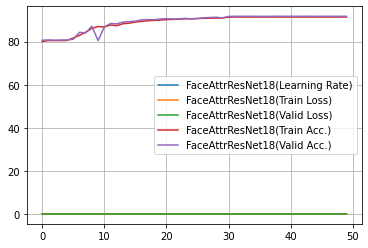

In [20]:
# config.epoch = 1
start_time = time.time()
model = create_model(device)
dataloaders, attribute_names  = load_dataloaders()
criterion = get_criterion()
optimizer = get_optimizer(model)

if config.evaluate:
    best_prec1, _, _ = resume_checkpoint(model, optimizer, config.ckp_logger_fname, config.checkpoint_fname) # checkpoint_fname bestmodel_fname
    test_loss, prec1, top1 = validate(dataloaders['test'], model, criterion)
    print(f"=> Best test accuracy: {prec1}, Model val acc: {best_prec1}")
    print_attribute_acc(top1, attribute_names)
else:
    best_prec1, start_epoch, logger = resume_checkpoint(model, optimizer, config.ckp_logger_fname, config.ckp_resume)
    run_name, run_time = get_run_name_time(model, criterion, optimizer, comments)
    trainer(dataloaders, model, criterion, optimizer, logger, start_epoch, best_prec1, run_name)
end_time = time.time()
time_taken = time.strftime("%H:%M:%S", time.gmtime(end_time - start_time))
print(f"total time taken: {time_taken}")

## Testing Loop

In [21]:
if not config.evaluate:
    config.evaluate = True
    model = create_model(device)
    dataloaders, attribute_names = load_dataloaders()
    criterion = get_criterion()
    optimizer = get_optimizer(model)

    best_prec1, _, _ = resume_checkpoint(model, optimizer, config.ckp_logger_fname, config.bestmodel_fname)# config.bestmodel_fname  config.checkpoint_fname
    print(model)
    test_loss, prec1, top1 = validate(dataloaders['test'], model, criterion)
    print(f"=> Best test accuracy: {prec1}, Model val acc: {best_prec1}")
    print_attribute_acc(top1, attribute_names)

=> creating model 'FaceAttrResNet'
Dataset sizes: {'test': 19962}
Class Labels: 40
=> resuming model: checkpoints\model_best.pth.tar
=> loading checkpoint 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/156 [00:00<?, ?it/s]

=> loaded checkpoint 'checkpoints\model_best.pth.tar' (epoch 39)
FaceAttrResNet(
  (pretrained): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   

100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:29<00:00,  5.36it/s]

(156/156) Data: 0.054s | Batch: 0.183s | Total: 0:00:28 | ETA: 0:00:01 | Loss: 0.0017 | top1:  91.2471
=> Best test accuracy: 91.24711950997911, Model val acc: 91.79267126175445
5_o_Clock_Shadow: 94.2691112862669
Arched_Eyebrows: 83.41849511172057
Attractive: 82.5017533236856
Bags_Under_Eyes: 84.68089365980666
Bald: 98.95301072342627
Bangs: 96.09257586591649
Big_Lips: 71.11511871105516
Big_Nose: 84.08476101082535
Black_Hair: 90.04107803529709
Blond_Hair: 96.00741406153992
Blurry: 96.20779477574163
Brown_Hair: 89.32972646731794
Bushy_Eyebrows: 92.88648428886833
Chubby: 95.65173827755035
Double_Chin: 96.27792806943545
Eyeglasses: 99.59422903516682
Goatee: 97.38503154085414
Gray_Hair: 98.14647827438907
Heavy_Makeup: 91.30848611981294
High_Cheekbones: 87.63149981455244
Male: 98.2466686704739
Mouth_Slightly_Open: 93.728083333156
Mustache: 96.89409879381176
Narrow_Eyes: 87.40607149769866
No_Beard: 95.9973950161985
Oval_Face: 75.4182947585153
Pale_Skin: 97.02935578208948
Pointy_Nose: 76.95120

## Save & Backup

In [22]:
# Wait for notebook to save
%autosave 1
time.sleep(150)
%autosave 120

Autosaving every 1 seconds


Autosaving every 120 seconds


In [23]:
def backup_everything(run_time, run_name, title):
    # backup checkpoints
    run_dir = os.path.join(config.BACKUP_DIR, run_name, run_time)
    create_dir_ifne(run_dir)
    fromDirectory = config.CHECKPOINT_DIR
    toDirectory = run_dir
    copy_tree(fromDirectory, toDirectory)
    # backup notebook html
    nb_name = title + '.ipynb'
    html_name = title + '.html'
    save_name = os.path.join(run_dir, html_name)
    !jupyter nbconvert --to html $nb_name
    !move $html_name $save_name
    
backup_everything(run_time, run_name, title)

[NbConvertApp] Converting notebook ai6126-project1-colab-v0.9.ipynb to html
[NbConvertApp] Writing 1000774 bytes to ai6126-project1-colab-v0.9.html


        1 file(s) moved.


In [24]:
if config.auto_hibernate and False:
    os.system('shutdown -h')